In [1]:
#IMPORT LIBRARIES

import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from __future__ import print_function
from IPython.display import clear_output as clc

plt.style.use('default')

In [2]:
# DEFINE COLORMAP

from matplotlib import colors
ice = sns.color_palette("icefire", as_cmap=True).colors
col = [ice[i] for i in np.concatenate((np.arange(128,0,-10), np.arange(254,128,-9)))]
col.insert(0, "black")
cmap = colors.LinearSegmentedColormap.from_list("", col)

# Kuramoto-Sivashinsky equation

\begin{cases}
\dfrac{\partial u(x,t)}{\partial t} + \dfrac{\partial^2 u(x,t)}{\partial x^2} + \dfrac{\partial^4 u(x,t)}{\partial x^4} + u(x,t)\dfrac{\partial u(x,t)}{\partial x} = 0 \qquad &\mathrm{in } \ (0,L) \times (0,T)
\\[7pt]
u(0,t) = u(L,t) \qquad &\mathrm{on } \ \{x=0,x=L\} \times (0,T)
\\[7pt]
\dfrac{\partial u(0,t)}{\partial x} = \dfrac{\partial u(L,t)}{\partial x} \qquad &\mathrm{on } \ \{x=0,x=L\} \times (0,T)
\\[7pt]
\dfrac{\partial^2 u(0,t)}{\partial x^2}  = \dfrac{\partial^2 u(L,t)}{\partial x^2} \qquad &\mathrm{on } \ \{x=0,x=L\} \times (0,T)
\\[7pt]
\dfrac{\partial^3 u(0,t)}{\partial x^3} = \dfrac{\partial^3 u(L,t)}{\partial x^3} \qquad &\mathrm{on } \ \{x=0,x=L\} \times (0,T)
\\[7pt]
u(x,0) = \cos \left( \frac{2 \pi \omega}{L}x \right) \left(1 + \sin \left( \frac{2 \pi \omega}{L}x \right) \right) \qquad & \mathrm{in} \ (0,L) \times \{t=0\}
\end{cases}


where $L$ is the domain length, $T > 0$ is the final time and $u: [0,L] \times [0,T] \to \mathbb{R}$ is the unknown field, $\nu$ is the viscosity and $\omega$ is the initial condition frequency  

In [3]:
# DOMAIN DISCRETIZATION

nstate = 2048
L = 2 * np.pi * 16
x = L * np.linspace(0, 1, nstate, endpoint=False)

In [5]:
# DEFINE THE STATE PROBLEM SOLVER

from tqdm import tqdm

def compute_state(nu, omega, dt, T, nstepsoutput = 300):
    """
    Compute the state trajectory
    Input: viscosity, initial condition frequency, time step, final time and number of steps to return
    Output: time-dependent state
    """

    u0 = lambda x: np.cos(omega * 2 * np.pi * x / L) * (1 + np.sin(omega * 2 * np.pi * x / L)) # initial condition

    v = np.fft.fft(u0(x))
    
    # Scalars for the Exponential Time Differencing fourth-order Runge-Kutta (ETDRK4)
    domain_length = x[-1] - x[0]
    k = 2 * np.pi / domain_length * np.transpose(np.conj(np.concatenate((np.arange(0, nstate/2), np.array([0]), np.arange(-nstate/2+1, 0))))) 
    l = k**2 - nu * k**4
    E = np.exp(dt*l)
    E2 = np.exp(dt*l/2)
    
    M = 16
    r = np.exp(1j*np.pi*(np.arange(1, M+1)-0.5) / M)
    LR = dt*np.transpose(np.repeat([l], M, axis=0)) + np.repeat([r], nstate, axis=0)
    Q  = dt*np.real(np.mean((np.exp(LR/2)-1)/LR, axis=1))
    f1 = dt*np.real(np.mean((-4-LR+np.exp(LR)*(4-3*LR+LR**2))/LR**3, axis=1))
    f2 = dt*np.real(np.mean((2+LR+np.exp(LR)*(-2+LR))/LR**3, axis=1))
    f3 = dt*np.real(np.mean((-4-3*LR-LR**2+np.exp(LR)*(4-LR))/LR**3, axis=1))
    
    u = np.array([u0(x)])
    ntimesteps = round(T / dt)
    freqoutput = round((T / nstepsoutput) / dt)
    g = -0.5j*k
    
    for i in tqdm(range(1, ntimesteps + 1), colour = "cyan", file = sys.stdout, bar_format = 'Computing state |{bar}| {n}/{total} {elapsed}<{remaining}'):
        Nv = g*np.fft.fft(np.real(np.fft.ifft(v))**2)
        a = E2*v + Q*Nv
        Na = g*np.fft.fft(np.real(np.fft.ifft(a))**2)
        b = E2*v + Q*Na
        Nb = g*np.fft.fft(np.real(np.fft.ifft(b))**2)
        c = E2*a + Q*(2*Nb-Nv)
        Nc = g*np.fft.fft(np.real(np.fft.ifft(c))**2)
        v = E*v + Nv*f1 + 2*(Na+Nb)*f2 + Nc*f3
        if i % freqoutput == 0:
            un = np.real(np.fft.ifft(v))
            u = np.append(u, np.array([un]), axis=0)
            
    return u

In [17]:
# SOLVE THE STATE PROBLEM

dt = 1e-2
T = 60.0
nstepsoutput = 150

nu = 1.0
omega = 2.0
        
ut = compute_state(nu, omega, dt, T, nstepsoutput)

Computing state |██████████| 6000/6000 00:01<00:00


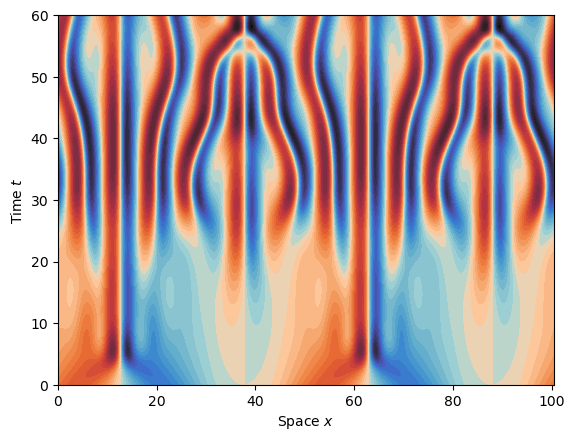

In [18]:
# STATE TRAJECTORY (PLOT)

def plot_state(u, cmap = "jet", title = None, colorbar = True, levels = 50, vmax = None, vmin = None):
    """
    State trajectory
    Input: state trajectory with dimension (ntimes, nstate) and plot functionalities
    """

    times = np.linspace(0, T, u.shape[0])

    xgrid, timesgrid = np.meshgrid(x, times)
    
    fig = plt.contourf(xgrid, timesgrid, u, cmap = cmap, levels = levels, vmax = vmax, vmin = vmin)
    
    plt.xlabel(r"Space $x$")
    plt.ylabel(r"Time $t$")
    plt.xlim((x[0], x[-1]))
    plt.ylim(times[0], times[-1])
    plt.title(title)

    if colorbar:
        plt.colorbar(fig)

plot_state(ut, cmap, colorbar = False)

# Snapshots generation

In [12]:
# GENERATE SNAPSHOTS (SKIP THIS CELL IF DATA ALREADY AVAILABLE)

dt = 1e-2
T = 60.0
nstepsoutput = 300
ntimes = nstepsoutput + 1 # Time series length

ntrajectories = 500
nparams = 2

params_range = [(0.5, 2.0), (1.0, 5.0)] # Physical parameters: viscosity and initial condition frequency

filename = 'Data/KuramotoSivashinsky_data'
U = torch.zeros(ntrajectories, ntimes, nstate)
MU = torch.zeros(ntrajectories, ntimes, nparams)

for i in range(ntrajectories):

    print(f"Generating snapshots n.{i}...")
    
    params = [0] * len(params_range)
    for j in range(len(params_range)):
        params[j] = ((params_range[j][1] - params_range[j][0]) * torch.rand(1) + params_range[j][0]).item()  
    
    ut = compute_state(params[0], params[1], dt, T, nstepsoutput)

    U[i] = torch.from_numpy(ut)
    
    for j in range(ntimes):
        MU[i,j] = torch.tensor(params)

    clc(wait = True)

print("Snapshots generated!")

np.savez("%s.npz" % filename.replace(".npz",""), u = U, mu = MU)

Snapshots generated!


In [18]:
# LOAD SNAPSHOTS MATRICES

dt = 1e-2
T = 60.0
nstepsoutput = 300
ntimes = nstepsoutput + 1 # Time series length

ntrajectories = 500
nparams = 2

filename = 'Data/KuramotoSivashinsky_data'
Data = np.load("%s.npz" % filename.replace(".npz",""))
U = torch.tensor(Data["u"])
MU = torch.tensor(Data["mu"])

del Data

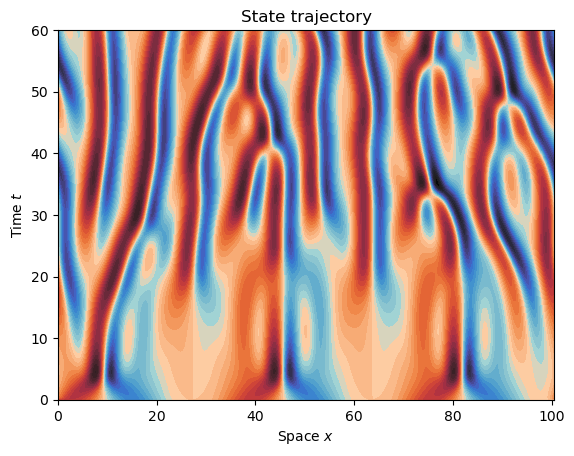

In [14]:
# TRAJECTORY EXAMPLE (PLOT)

which = 0

plot_state(U[which], cmap, colorbar = False, title = "State trajectory")

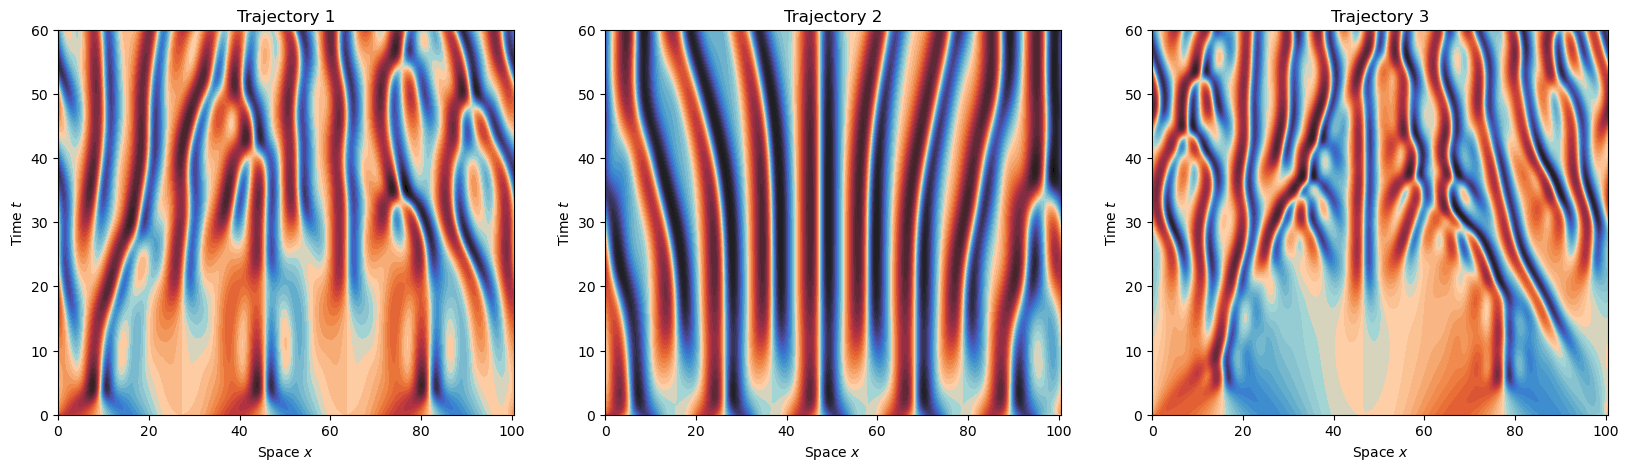

In [15]:
# TRAJECTORY EXAMPLES (PLOT)

from utils.processdata import multiplot

which = (0, 1, 2)
plotlist = [U[which[0]], U[which[1]], U[which[2]]]

plot_state_wrapper = lambda u: plot_state(u, cmap = cmap, colorbar = False)

multiplot(plotlist, plot_state_wrapper, titles = ("Trajectory 1", "Trajectory 2", "Trajectory 3"), figsize = (20,5), axis = True)

In [ ]:
# TRAIN-VALIDATION-TEST SPLITTING

np.random.seed(0)

ntrain = round(0.8 * ntrajectories)

idx_train = np.random.choice(ntrajectories, size = ntrain, replace = False)
mask = np.ones(ntrajectories)
mask[idx_train] = 0
idx_valid_test = np.arange(0, ntrajectories)[np.where(mask!=0)[0]]
idx_valid = idx_valid_test[::2]
idx_test = idx_valid_test[1::2]

nvalid = idx_valid.shape[0]
ntest = idx_test.shape[0]

Utrain = U[idx_train]
Uvalid = U[idx_valid]
Utest = U[idx_test]
MUtrain = MU[idx_train]
MUvalid = MU[idx_valid]
MUtest = MU[idx_test]

del U, MU

# State reduction - POD

In [37]:
# IMPORT FUNCTIONS FOR COMPUTING ERRORS

from utils.processdata import mre, num2p # Error metrics and format

In [38]:
# RESHAPE MATRICES

Utrain = Utrain.reshape(-1, nstate).numpy()
Uvalid = Uvalid.reshape(-1, nstate).numpy()
Utest = Utest.reshape(-1, nstate).numpy()

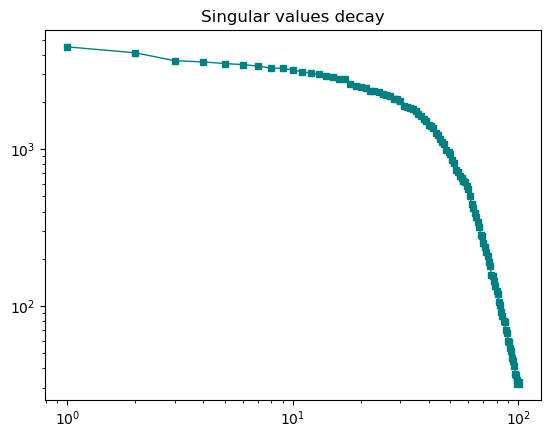

In [39]:
# PRINCIPAL ORTHOGONAL DECOMPOSITION FOR U

from sklearn.utils.extmath import randomized_svd

kstate = 100 # Number of POD modes

W, S, V = randomized_svd(Utrain, n_components = kstate)

teal = sns.light_palette("teal", 15)
plt.plot([i for i in range(1, kstate + 1)], S, color = teal[14], marker = 's', markersize = 5, linewidth = 1)
plt.ticklabel_format(axis = 'y', style = 'sci', scilimits = (0,0))
plt.loglog(kstate, S[kstate-1], color = teal[14], marker = 's', linestyle = '--')
plt.title("Singular values decay");

Utrain_POD = Utrain @ V.transpose()
Uvalid_POD = Uvalid @ V.transpose()
Utest_POD = Utest @ V.transpose()
Utrain_reconstructed = W @ np.diag(S) @ V
Uvalid_reconstructed = Uvalid @ V.transpose() @ V
Utest_reconstructed = Utest @ V.transpose() @ V

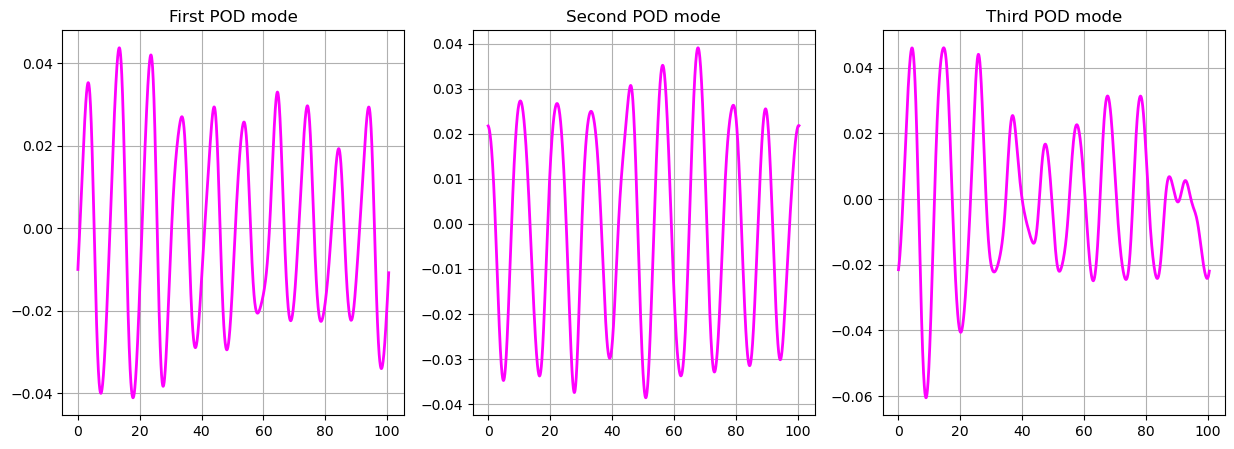

In [40]:
# POD MODES (PLOT)

plotlist = [V[0], V[1], V[2]]

def plot_mode(u, title = None, colorbar = False):  
    """
    POD mode
    Input: POD mode with dimension (nstate) and plot functionalities
    """

    plt.plot(x, u, color = "magenta", linewidth = 2)
    plt.grid()

multiplot(plotlist, plot_mode, titles = ("First POD mode", "Second POD mode", "Third POD mode"), axis = True, figsize = (15, 5))

In [41]:
# SCALING

from sklearn.preprocessing import MinMaxScaler

scalerU = MinMaxScaler()
scalerU = scalerU.fit(Utrain_POD)
Utrain_POD = scalerU.transform(Utrain_POD)
Uvalid_POD = scalerU.transform(Uvalid_POD)
Utest_POD = scalerU.transform(Utest_POD)

In [42]:
# RESHAPE MATRICES

Utrain = torch.from_numpy(Utrain.reshape(ntrain, ntimes, nstate))
Uvalid = torch.from_numpy(Uvalid.reshape(nvalid, ntimes, nstate))
Utest = torch.from_numpy(Utest.reshape(ntest, ntimes, nstate))
Utrain_POD = torch.from_numpy(Utrain_POD.reshape(ntrain, ntimes, kstate))
Uvalid_POD = torch.from_numpy(Uvalid_POD.reshape(nvalid, ntimes, kstate))
Utest_POD = torch.from_numpy(Utest_POD.reshape(ntest, ntimes, kstate))
Utrain_reconstructed = torch.from_numpy(Utrain_reconstructed.reshape(ntrain, ntimes, nstate))
Uvalid_reconstructed = torch.from_numpy(Uvalid_reconstructed.reshape(nvalid, ntimes, nstate))
Utest_reconstructed = torch.from_numpy(Utest_reconstructed.reshape(ntest, ntimes, nstate))

In [43]:
# POD RECONSTRUCTION ERRORS ON TEST DATA

print("Mean relative POD reconstruction error on U: %s" % num2p(mre(Utest, Utest_reconstructed)))

Mean relative POD reconstruction error on U: 0.11%


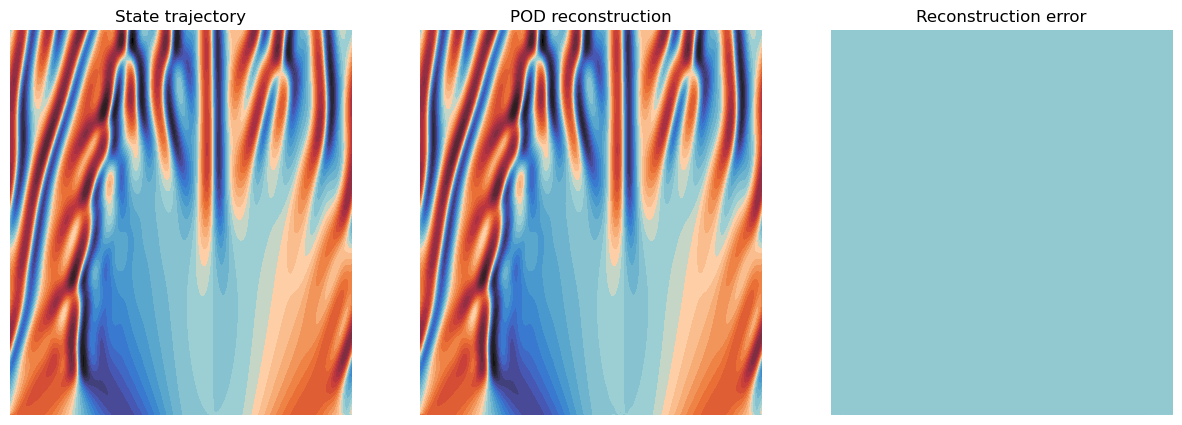

In [44]:
# FOM vs POD RECONSTRUCTION (PLOTS)

which = -1

plotlist = [Utest[which], Utest_reconstructed[which], np.sqrt((Utest[which] - Utest_reconstructed[which])**2)]
vmin = min(plotlist[i].min() for i in range(len(plotlist)))
vmax = max(plotlist[i].max() for i in range(len(plotlist)))

plot_state_wrapper = lambda u: plot_state(u, cmap = cmap, colorbar = False, vmin = vmin, vmax = vmax)

multiplot(plotlist, plot_state_wrapper, titles = ("State trajectory", "POD reconstruction", "Reconstruction error"), figsize = (15, 5))

# SHRED-ROM

In [45]:
# EXTRACT SENSORS DATA (SKIP THIS CELL IF DATA ALREADY AVAILABLE)

nsensors = 2
idx_sensors = np.random.choice(nstate, size = nsensors, replace = False)
sensors_coordinates = x[idx_sensors]

sensors_data_train = Utrain[:,:,idx_sensors]
sensors_data_valid = Uvalid[:,:,idx_sensors]
sensors_data_test = Utest[:,:,idx_sensors]

In [29]:
# LOAD SENSORS DATA

nsensors = 2
idx_sensors = torch.load('Data/KuramotoSivashinsky_idx_sensors.pt', weights_only = False)
sensors_coordinates = x[idx_sensors]

sensors_data_train = Utrain[:,:,idx_sensors]
sensors_data_valid = Uvalid[:,:,idx_sensors]
sensors_data_test = Utest[:,:,idx_sensors]

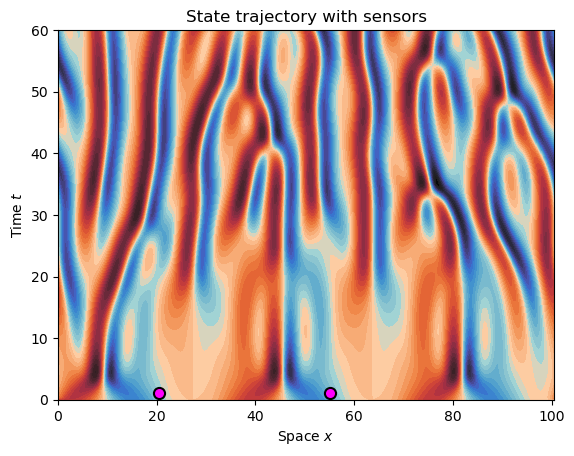

In [ ]:
# TRAJECTORY WITH SENSORS (PLOT) 

def trajectory_with_sensors(ut, sensors_coordinates, cmap = "jet", title = None, colorbar = False, levels = 50, vmax = None, vmin = None):
    """
    State trajectory with sensors
    Input: state trajectory with dimension (ntimes, nstate), sensors coordinates with dimension (nsensors) and plot functionalities
    """

    plot_state(ut, cmap = cmap, title = title, colorbar = colorbar, levels = levels, vmax = vmax, vmin = vmin)
    for k in range(nsensors):
        plt.plot(sensors_coordinates[k], 1.1, 'o', mfc = 'magenta', mec = 'black', ms = 8, mew = 1.5)

which = 0

trajectory_with_sensors(Utrain[which], sensors_coordinates, cmap = cmap, title = "State trajectory with sensors")

In [51]:
# BUILD TRAIN, VALIDATION AND TEST DATASETS WITH PADDING

from utils.processdata import Padding, TimeSeriesDataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

lag = 50

train_data_in = Padding(sensors_data_train, lag).to(device)
valid_data_in = Padding(sensors_data_valid, lag).to(device)
test_data_in = Padding(sensors_data_test, lag).to(device)

train_data_out = Padding(Utrain_POD, 1).squeeze(1).to(device)
valid_data_out = Padding(Uvalid_POD, 1).squeeze(1).to(device)
test_data_out = Padding(Utest_POD, 1).squeeze(1).to(device)

train_dataset = TimeSeriesDataset(train_data_in, train_data_out)
valid_dataset = TimeSeriesDataset(valid_data_in, valid_data_out)
test_dataset = TimeSeriesDataset(test_data_in, test_data_out)

In [52]:
# SHRED TRAINING (SKIP THIS CELL IF SHRED ALREADY AVAILABLE)

from utils.models import SHRED, fit

shred = SHRED(nsensors, kstate, hidden_size = 64, hidden_layers = 2, decoder_sizes = [350, 400], dropout = 0.1).to(device)
train_errors, valid_errors = fit(shred, train_dataset, valid_dataset, batch_size = 64, epochs = 100, lr = 1e-3, verbose = True, patience = 100)

OutOfMemoryError: CUDA out of memory. Tried to allocate 30.65 GiB. GPU 0 has a total capacity of 47.50 GiB of which 30.24 GiB is free. Including non-PyTorch memory, this process has 17.24 GiB memory in use. Of the allocated memory 2.17 GiB is allocated by PyTorch, and 14.57 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
train_errors, valid_errors = fit(shred, train_dataset, valid_dataset, batch_size = 64, epochs = 100, lr = 1e-4, verbose = True, patience = 100)

Training done: Training loss = 4.94% 	 Validation loss = 12.30%      


In [ ]:
# # SHRED LOADING

# from utils.models import SHRED, fit

# shred = SHRED(nsensors + nparams, kvelocity, hidden_size = 64, hidden_layers = 2, decoder_sizes = [350, 400], dropout = 0.1).to(device)
# shred.load_state_dict(torch.load('NN/FlowAroundObstacle_shred_velocity.pt', weights_only = True, map_location = torch.device(device)));

In [96]:
# SHRED ERRORS ON TEST DATA

shred.freeze()

Utest_POD_hat = shred(test_data_in).cpu()
Utest_hat = torch.from_numpy(scalerU.inverse_transform(Utest_POD_hat)) @ V
Utest_hat = Utest_hat.reshape(ntest, ntimes, nstate)

print("Mean relative SHRED prediction error on V: %s" % num2p(mre(Utest, Utest_hat)))

Mean relative SHRED prediction error on V: 70.83%


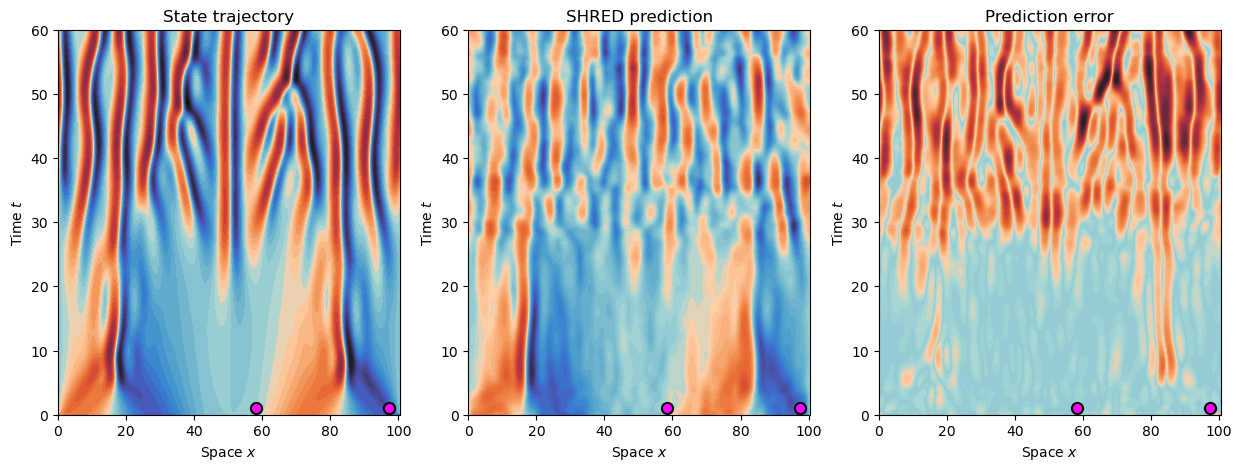

In [102]:
# TRAJECTORY WITH SENSORS (PLOT) 

def trajectories_with_sensors(uts, sensors_coordinates, cmap = "jet", titles = None, colorbar = False, levels = 50, vmax = None, vmin = None):
    """
    Trajectories with sensors
    Input: state trajectory with dimension (ntimes, nstate), sensors coordinates with dimension (nsensors) and plot functionalities
    """
    vmin = min(uts[j].min() for j in range(len(uts)))
    vmax = max(uts[j].max() for j in range(len(uts)))

    plt.figure(figsize = (15, 5))
    for j in range(len(uts)):
        plt.subplot(1, len(uts), j+1)
        plot_state(uts[j], cmap = cmap, title = titles[j], colorbar = colorbar, levels = levels, vmax = vmax, vmin = vmin)
        for k in range(nsensors):
            plt.plot(sensors_coordinates[k], 1.1, 'o', mfc = 'magenta', mec = 'black', ms = 8, mew = 1.5)

which = 5

plotlist = [Utest[which], Utest_hat[which], ((Utest[which] - Utest_hat[which])**2).sqrt()]

trajectories_with_sensors(plotlist, sensors_coordinates, cmap = cmap, titles = ("State trajectory", "SHRED prediction", "Prediction error"))

In [ ]:
# Gif con soluzione 1D che varia?

## Compute Measures

In [20]:
measured_field = 0

from tqdm import tqdm
num_sensors = 3
sensor_locations = np.arange(0, num_sensors, 1, dtype=int) # [0,1,2]

n_configurations = 4
idx_sensor_locations = np.zeros((num_sensors, n_configurations), dtype=int)
sensors = list()

snap_measurements = list()

np.random.seed(109) # set seed for reproducibility
for kk in tqdm(range(n_configurations), 'Creating sensors'):

    idx_sensor_locations[:, kk] = np.asarray(np.random.choice(domain, size=num_sensors, replace=False), dtype=int)

    snap_measurements.append({
        key: dataset[var_names[measured_field]][key][:, :, idx_sensor_locations[:,kk]]
        for key in list(dataset[var_names[measured_field]].keys())
    })

Creating sensors: 100%|██████████| 4/4 [00:00<00:00, 359.58it/s]


Let us add uncorrelated Gaussian noise to the measures

In [21]:
noise_value = 0.1
Xsensor = list()

for kk in range(n_configurations):
    Xsensor.append({
        key: snap_measurements[kk][key] + np.random.normal(scale=noise_value, size=snap_measurements[kk][key].shape)
        for key in list(snap_measurements[kk].keys())
    })

Plotting some measures

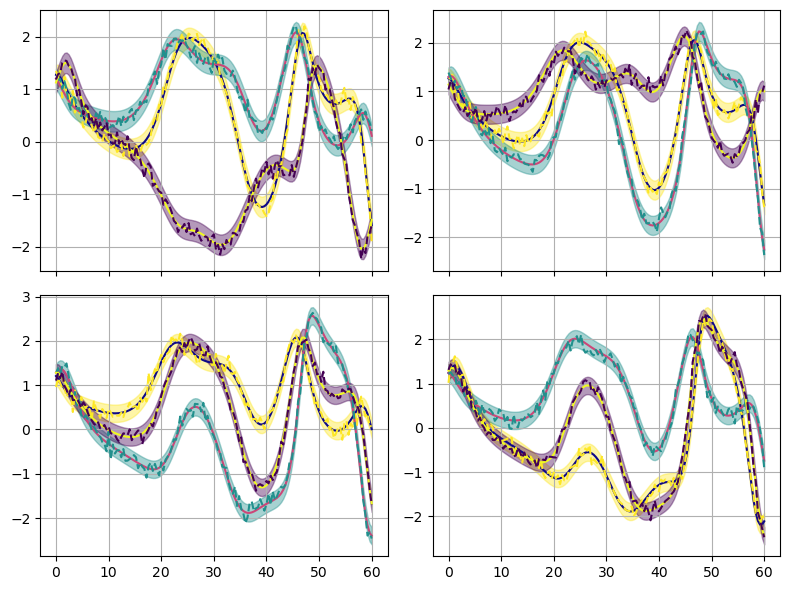

In [ ]:
ncols = 2
nrows = 2
fig, axs = plt.subplots(nrows = nrows, ncols=ncols, sharex=True, figsize= (4 * ncols, 3 * nrows))
axs = axs.flatten()

param_to_plot = 10

colors = cm.plasma(np.linspace(0,1,num_sensors))
colors_gt = cm.viridis_r(np.linspace(0,1,num_sensors))
for kk in range(nrows * ncols):
    for jj in range(num_sensors):
        axs[kk].plot(snaps['t'], snap_measurements[kk]['train'][param_to_plot, :, jj], color=colors[jj], label='True')
        axs[kk].plot(snaps['t'], Xsensor[kk]['train'][param_to_plot, :, jj],  '--', color=colors_gt[jj])
        axs[kk].fil_between(snaps['t'], snap_measurements[kk]['train'][param_to_plot, :, jj] - 1.96 * noise_value,
                             snap_measurements[kk]['train'][param_to_plot, :, jj] +  1.96 * noise_value, color=colors_gt[jj], alpha=0.4)
    axs[kk].grid()
    
plt.tight_layout()

Let us rescale the measures

In [49]:
from sklearn.preprocessing import MinMaxScaler

rescaled_Xsensor = list()
sens_scaler = list()
for kk in range(n_configurations):
    sens_scaler.append(MinMaxScaler())
    sens_scaler[kk].fit(Xsensor[kk]['train'].reshape(-1, num_sensors))

    rescaled_Xsensor.append({
        key: sens_scaler[kk].transform(Xsensor[kk][key].reshape(-1, num_sensors)).reshape(Xsensor[kk][key].shape)
        for key in list(Xsensor[kk].keys())
    })

print('Rescaled Sensors Shape')
print(rescaled_Xsensor[0]['train'].shape)
print(rescaled_Xsensor[0]['test'].shape)
print(rescaled_Xsensor[0]['valid'].shape)

Rescaled Sensors Shape
(212, 151, 3)
(19, 151, 3)
(19, 151, 3)


## Padding
In this section, the data are prepared to be fed into the SHRED architecture.

At first, let us load the POD coefficients and let us rescale them between 0 and 1.

In [50]:
assert sum(Nmodes) == v_POD['train'].shape[2]

vpod_scaler = MinMaxScaler()
vpod_scaler.fit(v_POD['train'].reshape(-1, sum(Nmodes)))

rescaled_v_POD = {
    key: vpod_scaler.transform(v_POD[key].reshape(-1, sum(Nmodes))).reshape(v_POD[key].shape)
    for key in list(v_POD.keys())
}

Let us rescale the parameters data

In [51]:
param_scaler = MinMaxScaler()
param_scaler.fit(dataset['params']['train'].reshape(-1, N_params))

rescaled_parameters = {
    key: param_scaler.transform(dataset['params'][key].reshape(-1, N_params)).reshape(dataset['params'][key].shape)
    for key in list(dataset['params'].keys())
}

print('Params Shape')
print(rescaled_parameters['train'].shape)
print(rescaled_parameters['test'].shape)
print(rescaled_parameters['valid'].shape)

print('POD Coeff Shape')
print(rescaled_v_POD['train'].shape)
print(rescaled_v_POD['test'].shape)
print(rescaled_v_POD['valid'].shape)

Params Shape
(212, 151, 2)
(19, 151, 2)
(19, 151, 2)
POD Coeff Shape
(212, 151, 40)
(19, 151, 40)
(19, 151, 40)


Let us use the Padding to prepare the data for the SHRED architecture

In [54]:
import sys

sys.path.append('../')

from utils.processdata import Padding, TimeSeriesDataset
import torch

lags = 10

train_data_in = [Padding(torch.from_numpy(rescaled_Xsensor[kk]['train']), lags) for kk in range(n_configurations)]
valid_data_in = [Padding(torch.from_numpy(rescaled_Xsensor[kk]['valid']), lags) for kk in range(n_configurations)]
test_data_in  = [Padding(torch.from_numpy(rescaled_Xsensor[kk]['test']), lags)  for kk in range(n_configurations)]

# Output composed by POD coefficients and Parameters
train_data_out = Padding(torch.cat((torch.from_numpy(rescaled_v_POD['train']), 
                                        torch.from_numpy(rescaled_parameters['train'])), 
                                        axis=2), 1).squeeze(1) 
valid_data_out = Padding(torch.cat((torch.from_numpy(rescaled_v_POD['valid']), 
                                        torch.from_numpy(rescaled_parameters['valid'])), 
                                        axis=2), 1).squeeze(1) 
test_data_out = Padding(torch.cat((torch.from_numpy(rescaled_v_POD['test']), 
                                        torch.from_numpy(rescaled_parameters['test'])), 
                                        axis=2), 1).squeeze(1) 
output_size = sum(Nmodes) + N_params    

train_dataset = [TimeSeriesDataset(train_data_in[kk], train_data_out) for kk in range(n_configurations)]
valid_dataset = [TimeSeriesDataset(valid_data_in[kk], valid_data_out) for kk in range(n_configurations)]
test_dataset  = [TimeSeriesDataset(test_data_in[kk], test_data_out)   for kk in range(n_configurations)]

## SHRED

Let us train the SHRED models for each configuration

In [ ]:
from utils.models import SHRED, fit

shred = list()

for kk in range(n_configurations):

    print('Training SHRED - configuration '+str(kk+1)+'/'+str(n_configurations))

    shred.append(SHRED( num_sensors, output_size, 
                        hidden_size = 64, hidden_layers = 2, decoder_sizes = [350, 400], dropout = 0.1))
    fitting_errors = fit(   shred[kk], train_dataset[kk], valid_dataset[kk], 
                            batch_size = 64, epochs = 3000, lr = 1e-4, verbose = True, patience = 50)

    print(' ')

Training SHRED - configuration 1/4


Let us check the test errors of the POD coefficients

In [28]:
from utils.processdata import num2p, mre

# Freeze SHRED weights
[_shred.freeze() for _shred in shred]

Ytest_POD_hat = np.asarray([shred[kk](test_data_in[kk]).numpy() for kk in range(n_configurations)])

Ytest_POD_pred = {
    'mean': Ytest_POD_hat.mean(axis=0),
    'std':  Ytest_POD_hat.std(axis=0)
}

print("Mean relative SHRED prediction error on POD coeffs: %s." % num2p(mre(test_data_out,
                                                                            Ytest_POD_pred['mean'])))

Mean relative SHRED prediction error on POD coeffs: 11.66%.


Let us reshape the output of the SHRED models and the associated test data to simplify the access to the variables.

In fact, the output of the SHRED models is a 2D array with dimensions $N_p^{test}\cdot N_t \times (R+N_{params})$, given $N_p$ the number of elements in the parameter test set, $N_t$ the number of time steps, $R$ the number of total rank of the latent space and $N_{params}$ the number of parameters (only 1, since $\tau$ only has been considered).

In [29]:
idx_params = {
    'train': idx_train,
    'valid': idx_valid,
    'test':  idx_test
}

reshaped_test_out = test_data_out.cpu().detach().numpy().reshape(len(idx_params['test']), Ntime_for_nn+1, output_size)

reshaped_POD_test_out = {
    'mean': Ytest_POD_pred['mean'].reshape(len(idx_params['test']), Ntime_for_nn+1, output_size)[:, :, :sum(Nmodes)],
    'std':  Ytest_POD_pred['std'].reshape(len(idx_params['test']), Ntime_for_nn+1, output_size)[:, :, :sum(Nmodes)]
}

Let us decode the ful state space

In [30]:
from tqdm import tqdm

ave_rel_errors = {
    'mean': np.zeros((len(var_names), len(idx_params['test']), Ntime_for_nn+1)),
    'std' : np.zeros((len(var_names), len(idx_params['test']), Ntime_for_nn+1))
}

for field_i in range(len(var_names)):
    field = var_names[field_i]
    idx_to_rec = np.arange(sum(Nmodes[:field_i]),  sum(Nmodes[:field_i+1]),  1, dtype=int)

    for param_to_recon in tqdm(range(len(idx_params['test'])), 'Computing error for '+field):
        fom = dataset[field]['test'][param_to_recon].T

        _tmp_mean_v = vpod_scaler.inverse_transform(reshaped_POD_test_out['mean'].reshape(-1, sum(Nmodes))).reshape(reshaped_POD_test_out['mean'].shape)
        _tmp_std_v  = vpod_scaler.inverse_transform(reshaped_POD_test_out['std'].reshape( -1, sum(Nmodes))).reshape(reshaped_POD_test_out['std'].shape) - vpod_scaler.data_min_

        recon     = rescaling_snaps[field_i].inverse_transform((u_total[field] @ np.diag(s_total[field]) @ _tmp_mean_v[param_to_recon, :, idx_to_rec]))
        std_recon = rescaling_snaps[field_i].inverse_std_transform((u_total[field] @ np.diag(s_total[field]) @ _tmp_std_v[ param_to_recon, :, idx_to_rec]))

        ave_rel_errors['mean'][field_i, param_to_recon] = np.linalg.norm(fom - recon, axis=0) / np.linalg.norm(fom, axis=0)
        ave_rel_errors['std'][field_i, param_to_recon]  = np.linalg.norm(std_recon, axis=0)   / np.linalg.norm(fom, axis=0)

Computing error for u: 100%|██████████| 30/30 [00:00<00:00, 162.84it/s]


Let us plot the errors using bar plots

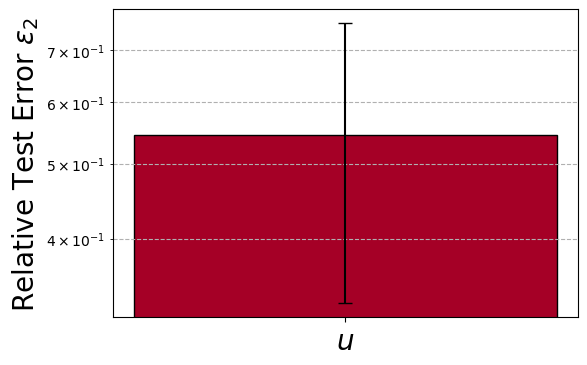

In [31]:
fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize=(6,4))

colors = cm.jet(np.linspace(0,1, len(var_names)))
axs.bar(np.arange(1, len(var_names)+1, 1), ave_rel_errors['mean'].mean(axis=2).mean(axis=1), 
        yerr = ave_rel_errors['mean'].std(axis=2).mean(axis=1), capsize=5,
        color = cm.RdYlBu(np.linspace(0,1,len(var_names))),
        edgecolor='k')

axs.set_yscale('log')
axs.set_xticks(np.arange(1,len(var_names)+1,1), ['$'+tex_+'$' for tex_ in var_names])
# axs.set_yticks(np.arange(0,0.1,0.01))

axs.tick_params(axis='both', labelsize=20)
axs.set_ylabel(r'Relative Test Error $\varepsilon_{2}$', fontsize=20)
axs.grid(axis='y', linestyle='-')
axs.grid(axis='y', which='minor', linestyle='--')

Let us make some contour plot

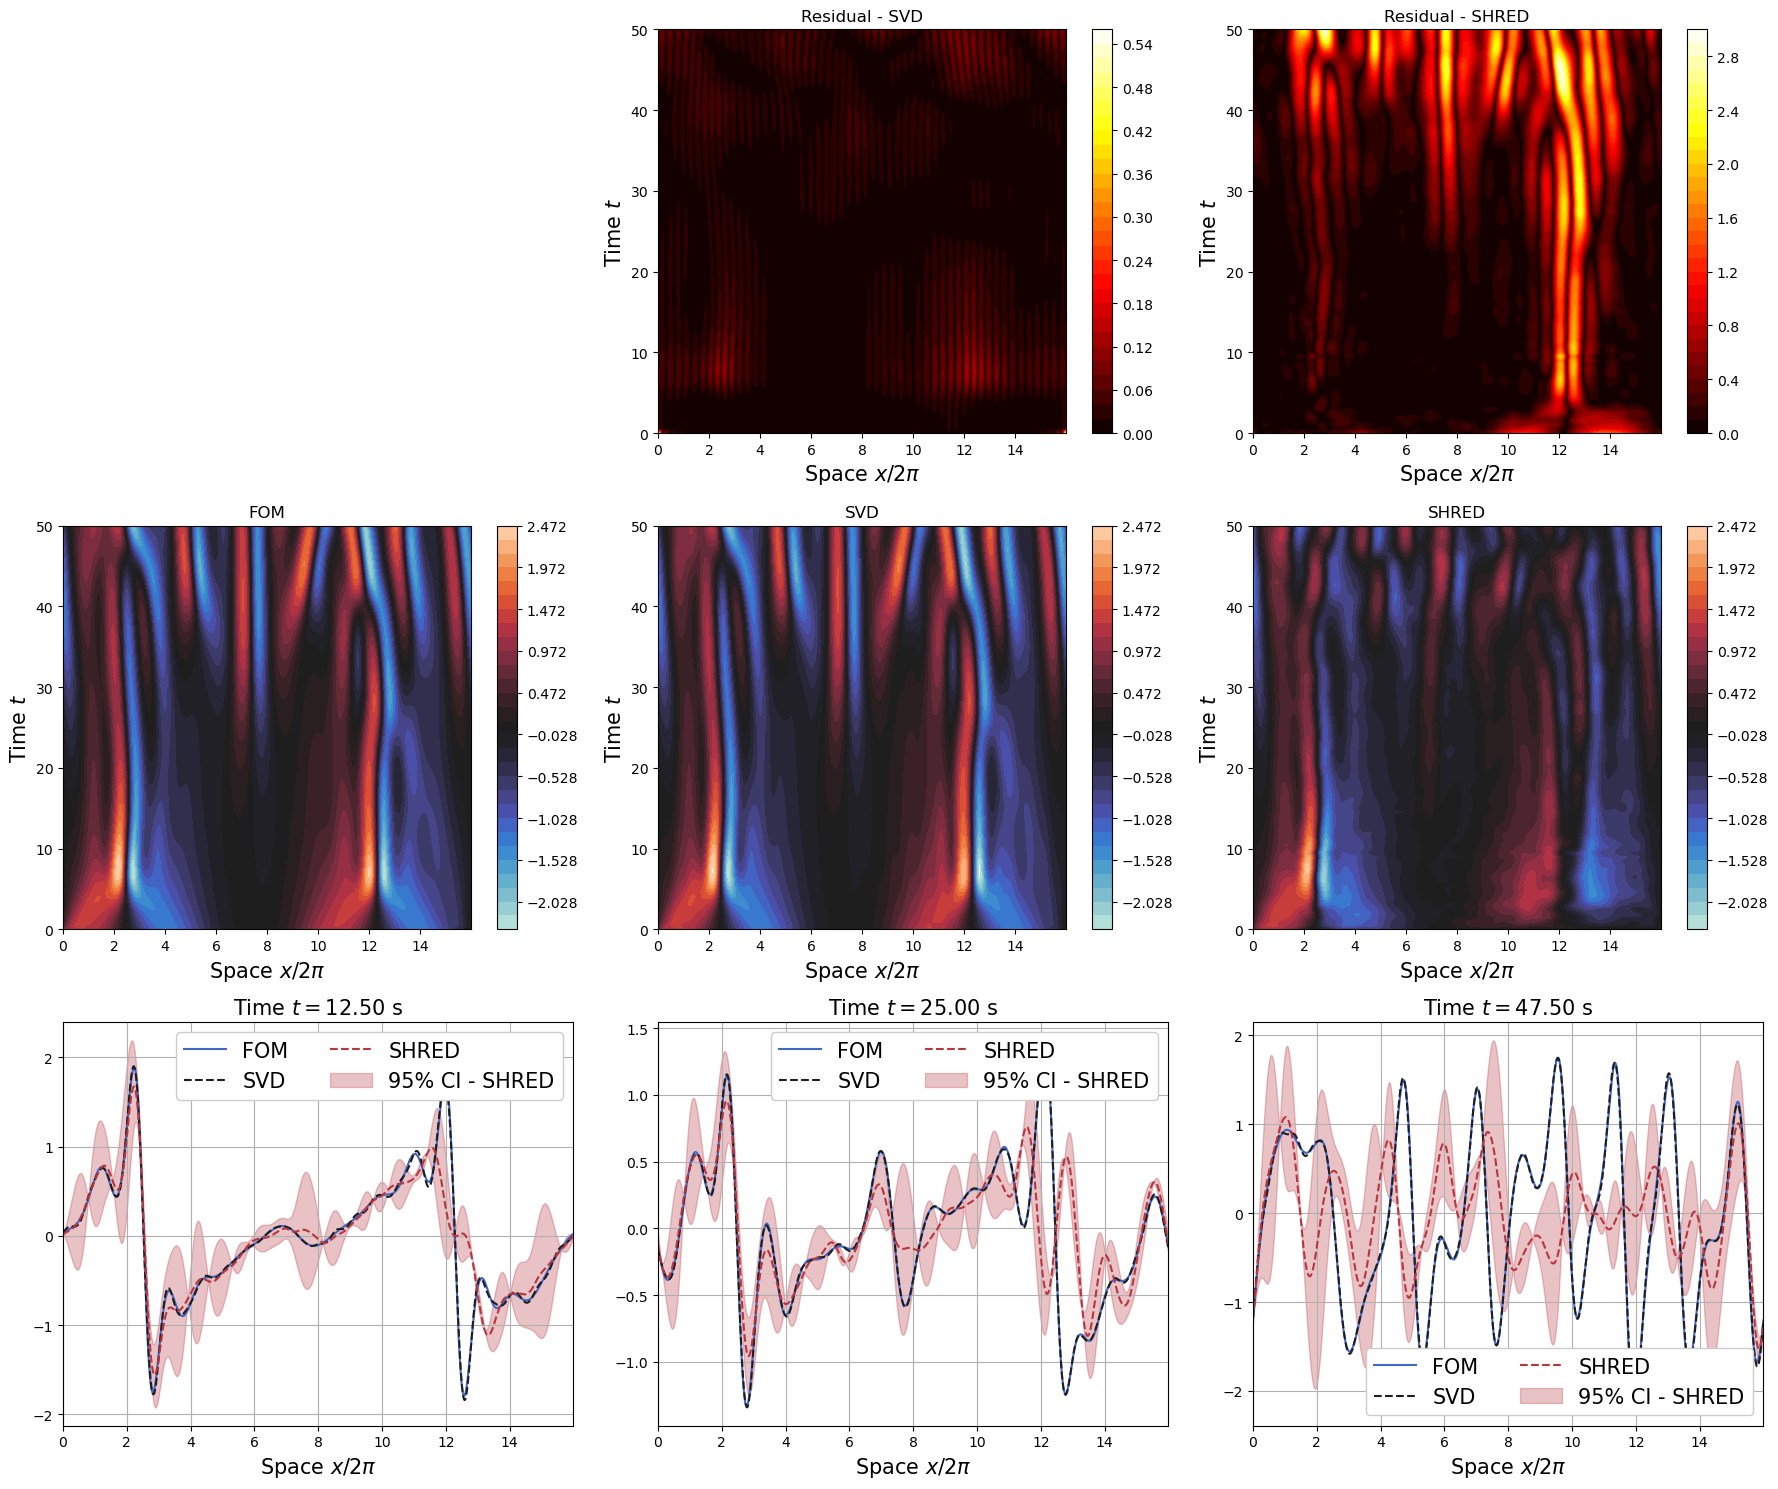

In [33]:
param_to_plot = 15

fom = dataset[field]['test'][param_to_plot].T

idx_to_rec = np.arange(sum(Nmodes[:field_i]),  sum(Nmodes[:field_i+1]),  1, dtype=int)

# Reconstruct the FOM with SVD
idx_to_rec = np.arange(sum(Nmodes[:field_i]),  sum(Nmodes[:field_i+1]),  1, dtype=int)
_tmp_mean_v = vpod_scaler.inverse_transform(reshaped_test_out[:, :, :sum(Nmodes)].reshape(-1, sum(Nmodes))).reshape(reshaped_POD_test_out['mean'].shape)

recon_svd = rescaling_snaps[field_i].inverse_transform((u_total[field] @ np.diag(s_total[field]) @ _tmp_mean_v[param_to_plot, :, idx_to_rec]))

# Reconstruct the FOM with SHRED
idx_to_rec = np.arange(sum(Nmodes[:field_i]),  sum(Nmodes[:field_i+1]),  1, dtype=int)
_tmp_mean_v = vpod_scaler.inverse_transform(reshaped_POD_test_out['mean'].reshape(-1, sum(Nmodes))).reshape(reshaped_POD_test_out['mean'].shape)
_tmp_std_v  = vpod_scaler.inverse_transform(reshaped_POD_test_out['std'].reshape( -1, sum(Nmodes))).reshape(reshaped_POD_test_out['std'].shape) - vpod_scaler.data_min_

recon_shred     = rescaling_snaps[field_i].inverse_transform((u_total[field] @ np.diag(s_total[field]) @ _tmp_mean_v[param_to_plot, :, idx_to_rec]))
recon_std_shred = rescaling_snaps[field_i].inverse_std_transform((u_total[field] @ np.diag(s_total[field]) @ _tmp_std_v[ param_to_plot, :, idx_to_rec]))

recons = {'SVD': recon_svd,
          'SHRED': recon_shred}

std_recons = {'SVD': None,
            'SHRED': recon_std_shred}

plot_FOM_vs_Recon(domain, snaps['t'], dataset[field]['test'][param_to_plot].T, recons,
                    std_recons = std_recons,
                    time_idx = [0.25, 0.5, 0.95])

This is the plot for the `README.md` file

In [27]:
from plots import plot_FOM_vs_SHRED

plot_FOM_vs_SHRED(domain, snaps['t'], dataset[field]['test'][param_to_plot].T, recons['SHRED'], 
                    filename = '../media/KuramotoSivashinsky', format = 'png', 
                    nlevels=100)